## Labelling pins as Inside and Outside of Connected Communities

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
from scipy import stats

In [2]:
# Load datasets
unique_pins_df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/unique_pins.csv", dtype={'pin': str})
filtered_pins_df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/filtered_high_density_zoning.csv", dtype={'pin': str})

# Ensure PIN format consistency (convert to string and remove any spaces)
unique_pins_df['pin'] = unique_pins_df['pin'].astype(str).str.strip()
filtered_pins_df['pin'] = filtered_pins_df['pin'].astype(str).str.strip()

# Add a column to indicate whether a PIN is inside a Connected Community
unique_pins_df['in_connected_community'] = unique_pins_df['pin'].isin(filtered_pins_df['pin']).map({True: 'inside', False: 'outside'})

# Save the updated dataframe
unique_pins_df.to_csv("C:/Users/kaur6/Downloads/Urban Analytics/unique_pins_with_cc_status.csv", index=False)

# Display first few rows to verify
print(unique_pins_df.head())

              pin in_connected_community
0  29204200060000                outside
1  13351120130000                outside
2  17223030580000                outside
3   3043040200000                outside
4  25011030050000                outside


#### The majority of parcels (over 1 million) are outside connected communities, while only about 81,647 parcels are inside connected communities.

#### This suggests that connected communities represent a smaller portion of the total parcels, possibly indicating selective urban planning or a focus on specific areas for connectivity improvements.

In [3]:
# Count unique values in the 'in_connected_community' column
community_counts = unique_pins_df['in_connected_community'].value_counts()

# Print the counts
print(community_counts)

in_connected_community
outside    1057562
inside       81647
Name: count, dtype: int64


## Getting data for pins which are inside of CC from main Cook County dataset

In [ ]:
# Load the connected community pins 
status_df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/filtered_high_density_zoning.csv", dtype={'pin': str})

# Ensure PIN format consistency
status_df['pin'] = status_df['pin'].astype(str).str.strip()

# Define chunk size for processing in chunks
chunksize = 1000000

# Specify the path to save the results
output_file = "C:/Users/kaur6/Downloads/Urban Analytics/processed_connected_community_data.csv"

# Initialize a counter for chunk processing
chunk_counter = 0

# Process the large dataset in chunks
for chunk in pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/final_cook_county_data_with_same_dtype.csv", dtype={'pin': str}, chunksize=chunksize):
    
    # Update chunk counter
    chunk_counter += 1
    print(f"Processing chunk {chunk_counter}...")

    # Ensure PIN format consistency
    chunk['pin'] = chunk['pin'].astype(str).str.strip()

    # Merge with status file to get the in_connected_community column
    merged_chunk = pd.merge(status_df, chunk, on='pin', how='inner')

    # Sort by 'pin' and 'tax_year' to keep only the latest tax year for each pin
    merged_chunk = merged_chunk.sort_values(by=['pin', 'tax_year'], ascending=[True, False])

    # Keep only the rows with the latest tax_year for each pin
    latest_chunk = merged_chunk.drop_duplicates(subset='pin', keep='first')

    # Save the processed chunk to the CSV file
    latest_chunk.to_csv(output_file, mode='a', header=notchunk_counter == 1, index=False)

# After processing all chunks, print a message
print(f"Processing complete! Processed {chunk_counter} chunks. Data saved to {output_file}.")

## Exploring the data

In [10]:
# Load your cleaned connected community data
df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/processed_connected_community_data.csv",  low_memory=False)

In [11]:
# 1. Check for Missing Values
print("Missing Values in Each Column:")
print(df.isnull().sum())
print("Dropping Missing Values")
df = df.dropna(subset=['pin'])
print(df.isnull().sum())

Missing Values in Each Column:
pin                             1
latitude                        1
longitude                       1
ZONE_CLASS                      1
tax_year                        1
card_num                        1
class                           1
township_code                   3
proration_key_pin           78584
pin_proration_rate              1
card_proration_rate             1
cdu                             1
pin_is_multicard                1
pin_num_cards                   1
pin_is_multiland                2
pin_num_landlines               1
year_built                      1
building_sqft                   1
land_sqft                       1
num_bedrooms                    1
num_rooms                       1
num_full_baths                  1
num_half_baths                  1
num_fireplaces                  1
type_of_residence             554
construction_quality            1
num_apartments                  1
attic_finish                    1
garage_attached  

In [12]:
# 2. Property Characteristics (Numerical Features)
property_columns = ['building_sqft', 'land_sqft', 'num_bedrooms', 'num_rooms', 'num_full_baths', 'num_half_baths']

# Summary statistics for numerical columns
print("\nSummary Statistics for Property Characteristics:")
print(df[property_columns].describe())


Summary Statistics for Property Characteristics:
       building_sqft      land_sqft  num_bedrooms     num_rooms  \
count   81638.000000   81638.000000  81638.000000  81638.000000   
mean     3037.329773    3329.495076      5.026324     10.548789   
std      2501.383226    3301.363608      2.972376      6.328775   
min        -1.000000      -1.000000     -1.000000     -1.000000   
25%      1760.000000    2592.000000      3.000000      6.000000   
50%      2480.000000    3125.000000      4.000000      8.000000   
75%      3693.000000    3750.000000      6.000000     13.000000   
max    309180.000000  584880.000000     90.000000     91.000000   

       num_full_baths  num_half_baths  
count    81638.000000    81638.000000  
mean         2.693023        0.456932  
std          1.577320        0.789693  
min         -1.000000       -1.000000  
25%          2.000000        0.000000  
50%          2.000000        0.000000  
75%          3.000000        1.000000  
max         88.000000     

In [13]:
invalid_count = df[df['building_sqft'] == -1].shape[0]
print(f"Number of rows with invalid building_sqft (-1): {invalid_count}")

invalid_count = df[df['land_sqft'] == -1].shape[0]
print(f"Number of rows with invalid land_sqft (-1): {invalid_count}")

invalid_count = df[df['num_bedrooms'] == -1].shape[0]
print(f"Number of rows with invalid num_bedrooms (-1): {invalid_count}")

invalid_count = df[df['num_rooms'] == -1].shape[0]
print(f"Number of rows with invalid num_rooms (-1): {invalid_count}")

invalid_count = df[df['num_full_baths'] == -1].shape[0]
print(f"Number of rows with invalid num_full_baths (-1): {invalid_count}")

invalid_count = df[df['num_half_baths'] < 0].shape[0]
print(f"Number of rows with invalid num_rooms (-1): {invalid_count}")

Number of rows with invalid building_sqft (-1): 538
Number of rows with invalid land_sqft (-1): 1781
Number of rows with invalid num_bedrooms (-1): 637
Number of rows with invalid num_rooms (-1): 641
Number of rows with invalid num_full_baths (-1): 637
Number of rows with invalid num_rooms (-1): 978


In [14]:
df = df[df['building_sqft'] != -1]
df = df[df['land_sqft'] != -1]
df = df[df['num_bedrooms'] != -1]
df = df[df['num_rooms'] != -1]
df = df[df['num_full_baths'] != -1]
df = df[df['num_half_baths'] >= 0]
# Summary statistics for numerical columns
print("\nSummary Statistics for Property Characteristics:")
print(df[property_columns].describe())


Summary Statistics for Property Characteristics:
       building_sqft      land_sqft  num_bedrooms     num_rooms  \
count   79322.000000   79322.000000  79322.000000  79322.000000   
mean     3033.663725    3391.271488      5.060803     10.628527   
std      1964.034574    3208.058333      2.895663      6.237445   
min         0.000000       7.000000      1.000000      2.000000   
25%      1782.000000    2675.000000      3.000000      6.000000   
50%      2490.000000    3125.000000      4.000000      9.000000   
75%      3696.000000    3750.000000      6.000000     13.000000   
max     32928.000000  584880.000000     36.000000     91.000000   

       num_full_baths  num_half_baths  
count    79322.000000    79322.000000  
mean         2.713875        0.479590  
std          1.470066        0.779487  
min          0.000000        0.000000  
25%          2.000000        0.000000  
50%          2.000000        0.000000  
75%          3.000000        1.000000  
max         22.000000     

#### Properties inside connected communities tend to be larger, well-equipped, and more valuable, suggesting affluent or planned residential developments.

#### There is significant variation, indicating a mix of single-family homes, luxury estates, and multi-unit buildings.

#### The presence of extremely large buildings and land plots suggests that connected communities include not just residential areas, but also commercial, institutional, or mixed-use spaces.

In [15]:
# 3. Age and Quality
# Check the range of 'year_built' and analyze construction quality & repair condition
print("\nYear Built Range:")
print(df['year_built'].describe())


Year Built Range:
count    79322.000000
mean      1928.701899
std         44.222214
min         -1.000000
25%       1894.000000
50%       1911.000000
75%       1962.000000
max       2024.000000
Name: year_built, dtype: float64


In [16]:
# Check how many rows had -1 in the 'year_built' column before replacing
invalid_count = df[df['year_built'] == -1].shape[0]
print(f"Number of rows with invalid year_built (-1): {invalid_count}")

Number of rows with invalid year_built (-1): 1


In [17]:
# Drop rows where 'year_built' is -1
df = df[df['year_built'] != -1]

# Verify the result by checking the summary again
print(df['year_built'].describe())

count    79321.000000
mean      1928.726226
std         43.688470
min       1844.000000
25%       1894.000000
50%       1911.000000
75%       1962.000000
max       2024.000000
Name: year_built, dtype: float64


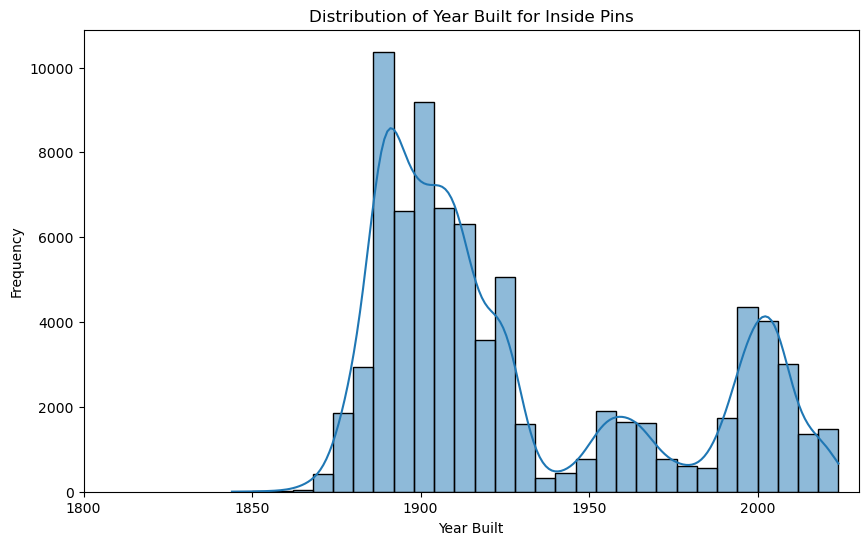

In [18]:
# Plot Year Built distribution with specified bins
plt.figure(figsize=(10,6))
sns.histplot(df['year_built'], bins=30, kde=True)

# Set x-axis limits and labels to focus on the range of year_built (1900 to 2025)
plt.xlim(1800, 2030)
plt.title("Distribution of Year Built for Inside Pins")
plt.xlabel("Year Built")
plt.ylabel("Frequency")
plt.show()

#### Properties that are part of connected communities are constructed mainly from 1880s to 1925, with some of them built during period of 1995 to 2005.

####  Recent years have a high concentration of buildings, suggests ongoing urban development and expansion in connected communities.

#### A mix of older and newer buildings suggests a blend of historical and modern architecture.

In [19]:
# Construction Quality & Repair Condition distribution
print("\nConstruction Quality Distribution:")
print(df['construction_quality'].value_counts())


Construction Quality Distribution:
construction_quality
Average    78223
Deluxe       986
Poor         112
Name: count, dtype: int64


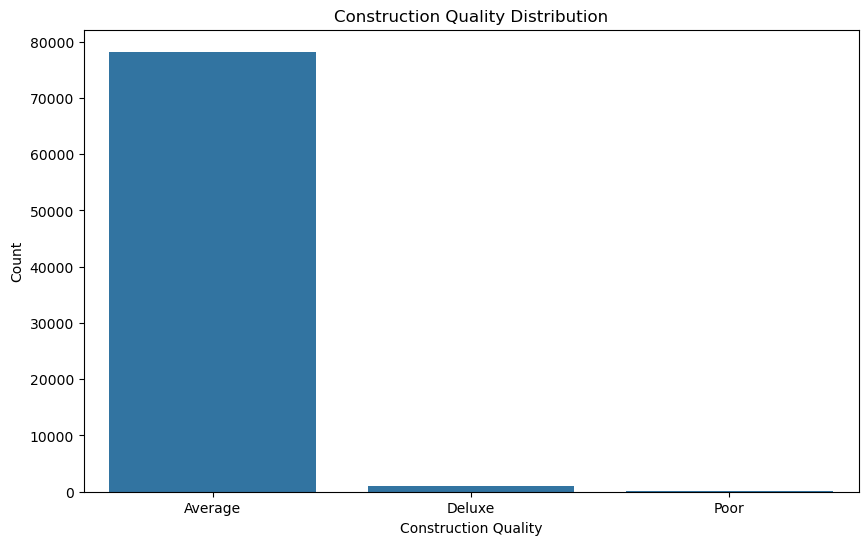

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(x='construction_quality', data=df)
plt.title("Construction Quality Distribution")
plt.xlabel("Construction Quality")
plt.ylabel("Count")
plt.show()

#### Properties inside connected communities generally have good to high construction quality, indicating that these areas maintain a certain standard of living.


Repair Condition Distribution:
repair_condition
Average          76786
Above Average     1311
Below Average     1211
Name: count, dtype: int64


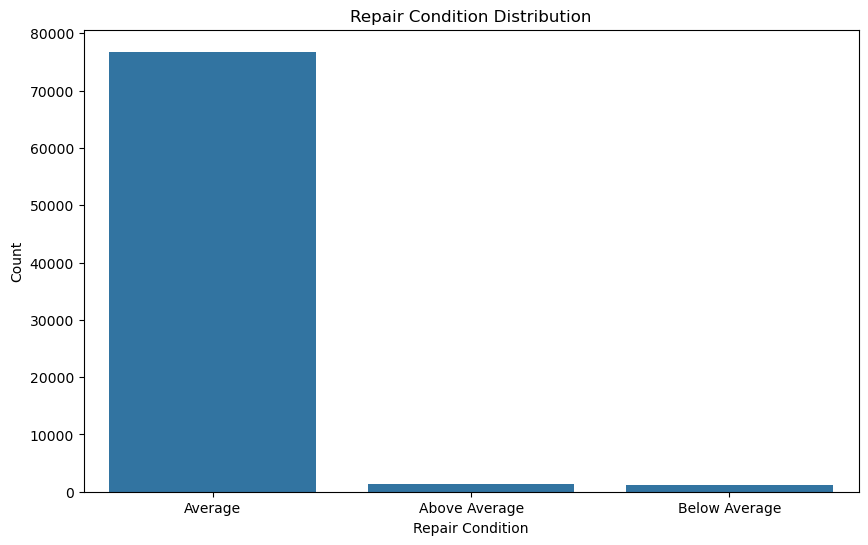

In [21]:
print("\nRepair Condition Distribution:")
print(df['repair_condition'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(x='repair_condition', data=df)
plt.title("Repair Condition Distribution")
plt.xlabel("Repair Condition")
plt.ylabel("Count")
plt.show()

#### Properties inside connected communities tend to be in good to excellent condition, likely due to better maintenance practices, community regulations, and possibly higher income levels among residents.

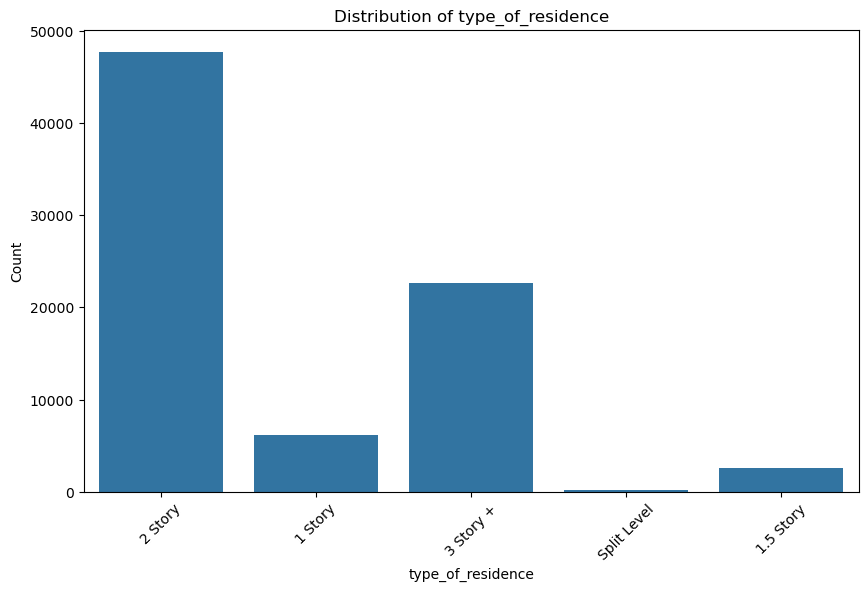

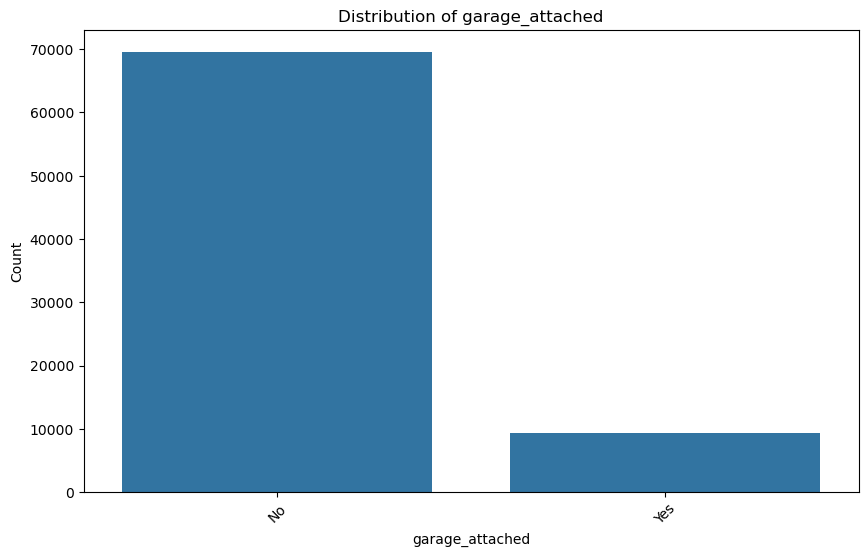

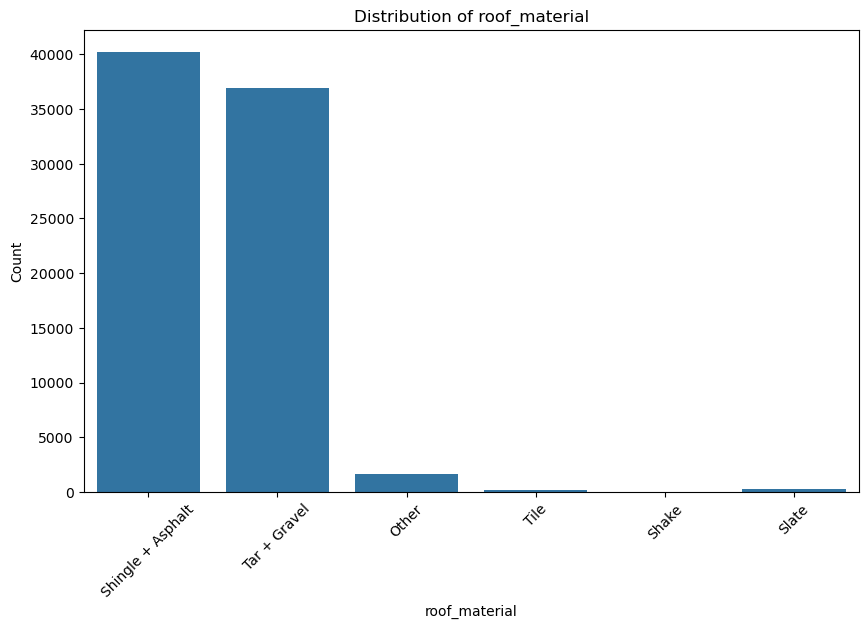

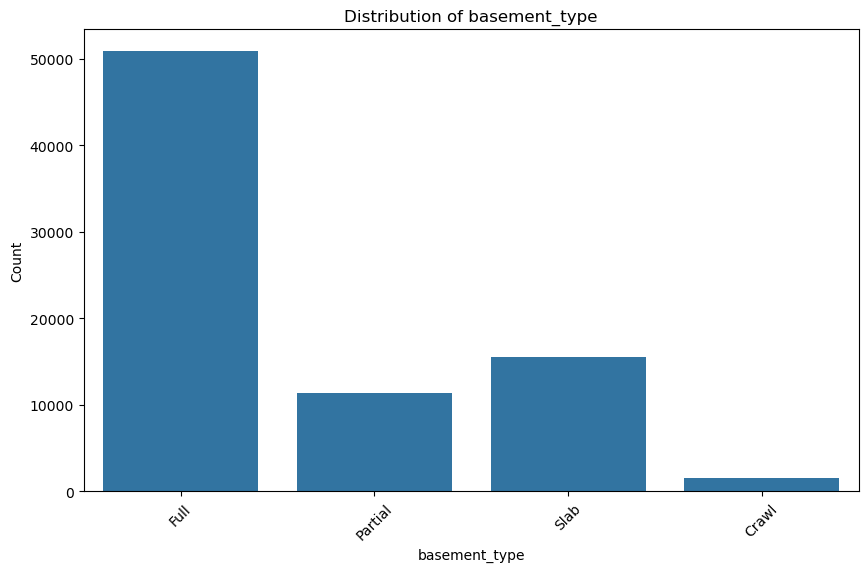

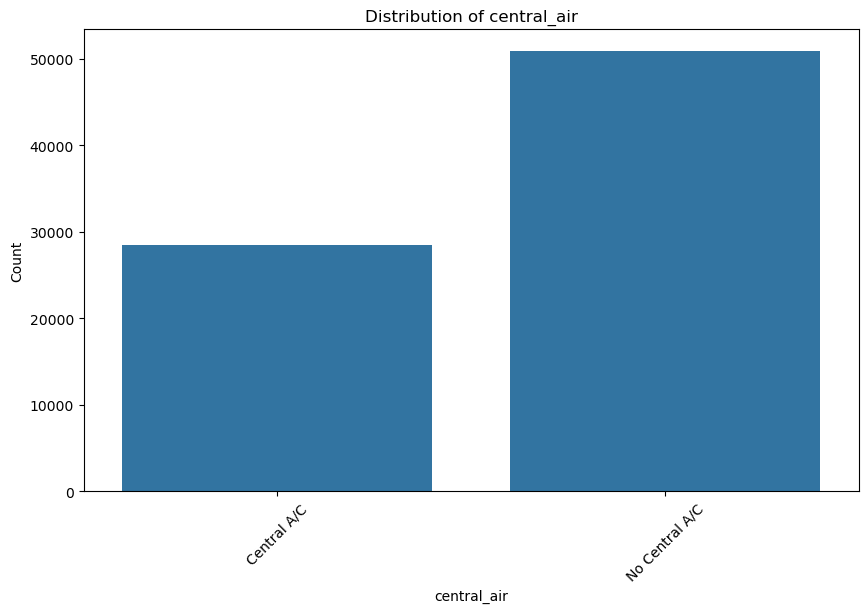

In [22]:
# 4. Categorical Variables Analysis
categorical_columns = ['type_of_residence', 'garage_attached', 'roof_material', 'basement_type', 'central_air']

# Plot distribution of categorical variables
for col in categorical_columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

#### Type of Residence: Most properties are 2 story and some are 3 story plus.
#### Garage Attached: Few homes have attached garages, connected communities rely on street or shared parking.
#### Roof Material: Asphalt shingles and Tar/ Gravel dominate, indicating a standardized construction trend.
#### Basement Type: The distribution of full basements, crawl spaces, or slab foundations reflects climate and soil conditions.
#### Central Air: Most homes lack central AC, it indicates either a cooler climate or an older housing stock.

In [23]:
# 5. Generate Summary of Insights
print("\nKey Insights:")
print(f"- Average building square footage: {df['building_sqft'].mean()} sq ft")
print(f"- Average number of bedrooms: {df['num_bedrooms'].mean()}")
print(f"- Proportion with garages: {df['garage_attached'].value_counts(normalize=True).get('Yes', 0)}")
print(f"- Proportion with central air: {df['central_air'].value_counts(normalize=True).get('Yes', 0)}")


Key Insights:
- Average building square footage: 3033.6853292318556 sq ft
- Average number of bedrooms: 5.060828784306804
- Proportion with garages: 0.11744029642413015
- Proportion with central air: 0


### Key Insights:
#### Homes are large (Avg: 3,033 sq ft), suggesting a premium market with spacious residences.
#### Most homes have 5+ bedrooms, indicating family-oriented housing or shared living spaces.
#### Only ~12% of homes have garages, meaning street/shared parking is common.
#### No homes have central air, likely due to a cool climate or older home designs.

## Getting data for pins which are outside of CC from main Cook County dataset

In [ ]:
status_df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/unique_pins_with_cc_status.csv", dtype={'pin': str})
outside_pins_df = status_df[status_df['in_connected_community'] == 'outside']
chunksize = 1000000
header_written = False
chunk_counter = 0
for chunk in pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/final_cook_county_data_with_same_dtype.csv", dtype={'pin': str}, low_memory=False, chunksize=chunksize):

    chunk_counter += 1
    print(f"Processing chunk {chunk_counter}...")
    
    merged_chunk = pd.merge(chunk, outside_pins_df[['pin']], on='pin', how='inner')
    
    merged_chunk['tax_year'] = pd.to_numeric(merged_chunk['tax_year'], errors='coerce')
    
    merged_chunk_sorted = merged_chunk.sort_values(by=['pin', 'tax_year'], ascending=[True, False])
    
    merged_chunk_latest = merged_chunk_sorted.drop_duplicates(subset=['pin'], keep='first')

    output_file = "C:/Users/kaur6/Downloads/Urban Analytics/processed_outside_community_data.csv"
    
    if not header_written:
        merged_chunk_latest.to_csv(output_file, mode='w', index=False)
        header_written = True
    else:
        merged_chunk_latest.to_csv(output_file, mode='a', header=False, index=False)

print(f"Processed data with outside pins and latest tax_year saved to 'processed_outside_community_data.csv'")

## Exploring Outside CC data

In [25]:
# Load your cleaned connected community data
df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/processed_outside_community_data.csv",  low_memory=False)

In [26]:
# 1. Check for Missing Values
print("Missing Values in Each Column:")
print(df.isnull().sum())

Missing Values in Each Column:
pin                               0
tax_year                          0
card_num                          0
class                             0
township_code                     6
proration_key_pin           1004216
pin_proration_rate                0
card_proration_rate               0
cdu                               0
pin_is_multicard                  0
pin_num_cards                     0
pin_is_multiland                  1
pin_num_landlines                 0
year_built                        0
building_sqft                     0
land_sqft                         0
num_bedrooms                      0
num_rooms                         0
num_full_baths                    0
num_half_baths                    0
num_fireplaces                    0
type_of_residence               832
construction_quality            202
num_apartments                    0
attic_finish                      0
garage_attached                2324
garage_area_included           23

In [27]:
# 2. Property Characteristics (Numerical Features)
property_columns = ['building_sqft', 'land_sqft', 'num_bedrooms', 'num_rooms', 'num_full_baths', 'num_half_baths']

# Summary statistics for numerical columns
print("\nSummary Statistics for Property Characteristics:")
print(df[property_columns].describe())


Summary Statistics for Property Characteristics:
       building_sqft     land_sqft  num_bedrooms     num_rooms  \
count   1.057586e+06  1.057586e+06  1.057586e+06  1.057586e+06   
mean    1.790491e+03  7.555367e+03  3.497130e+00  6.959682e+00   
std     1.318334e+03  2.485550e+04  1.406601e+00  3.088413e+00   
min    -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%     1.128000e+03  3.750000e+03  3.000000e+00  5.000000e+00   
50%     1.458000e+03  5.289000e+03  3.000000e+00  6.000000e+00   
75%     2.145000e+03  8.236000e+03  4.000000e+00  8.000000e+00   
max     6.438840e+05  8.848574e+06  3.000000e+01  9.700000e+01   

       num_full_baths  num_half_baths  
count    1.057586e+06    1.057586e+06  
mean     1.662814e+00    4.691628e-01  
std      9.245457e-01    5.787002e-01  
min     -1.000000e+00   -2.000000e+00  
25%      1.000000e+00    0.000000e+00  
50%      1.000000e+00    0.000000e+00  
75%      2.000000e+00    1.000000e+00  
max      9.900000e+01    7.100000e+

In [28]:
invalid_count = df[df['building_sqft'] == -1].shape[0]
print(f"Number of rows with invalid building_sqft (-1): {invalid_count}")

invalid_count = df[df['land_sqft'] == -1].shape[0]
print(f"Number of rows with invalid land_sqft (-1): {invalid_count}")

invalid_count = df[df['num_bedrooms'] == -1].shape[0]
print(f"Number of rows with invalid num_bedrooms (-1): {invalid_count}")

invalid_count = df[df['num_rooms'] == -1].shape[0]
print(f"Number of rows with invalid num_rooms (-1): {invalid_count}")

invalid_count = df[df['num_full_baths'] == -1].shape[0]
print(f"Number of rows with invalid num_full_baths (-1): {invalid_count}")

invalid_count = df[df['num_half_baths'] < 0].shape[0]
print(f"Number of rows with invalid num_rooms (-1): {invalid_count}")

Number of rows with invalid building_sqft (-1): 800
Number of rows with invalid land_sqft (-1): 12705
Number of rows with invalid num_bedrooms (-1): 1043
Number of rows with invalid num_rooms (-1): 1050
Number of rows with invalid num_full_baths (-1): 1051
Number of rows with invalid num_rooms (-1): 2515


In [29]:
df = df[df['building_sqft'] != -1]
df = df[df['land_sqft'] != -1]
df = df[df['num_bedrooms'] != -1]
df = df[df['num_rooms'] != -1]
df = df[df['num_full_baths'] != -1]
df = df[df['num_half_baths'] >= 0]

In [30]:
# Summary statistics for numerical columns
print("\nSummary Statistics for Property Characteristics:")
print(df[property_columns].describe())


Summary Statistics for Property Characteristics:
       building_sqft     land_sqft  num_bedrooms     num_rooms  \
count   1.042828e+06  1.042828e+06  1.042828e+06  1.042828e+06   
mean    1.781674e+03  7.632383e+03  3.487385e+00  6.933936e+00   
std     1.019792e+03  2.473835e+04  1.355437e+00  2.979106e+00   
min     0.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00   
25%     1.128000e+03  3.750000e+03  3.000000e+00  5.000000e+00   
50%     1.456000e+03  5.355000e+03  3.000000e+00  6.000000e+00   
75%     2.140000e+03  8.277000e+03  4.000000e+00  8.000000e+00   
max     3.797500e+04  8.848574e+06  2.400000e+01  9.700000e+01   

       num_full_baths  num_half_baths  
count    1.042828e+06    1.042828e+06  
mean     1.657161e+00    4.740235e-01  
std      8.950070e-01    5.719137e-01  
min      0.000000e+00    0.000000e+00  
25%      1.000000e+00    0.000000e+00  
50%      1.000000e+00    0.000000e+00  
75%      2.000000e+00    1.000000e+00  
max      4.200000e+01    7.100000e+

#### Properties outside connected communities show considerable variability in size and layout. Many properties are of moderate size, but there is a significant presence of large estates, with building and land sizes ranging widely.

In [31]:
# 3. Age and Quality
# Check the range of 'year_built' and analyze construction quality & repair condition
print("\nYear Built Range:")
print(df['year_built'].describe())
invalid_count = df[df['year_built'] == -1].shape[0]
print(f"Number of rows with invalid year_built (-1): {invalid_count}")


Year Built Range:
count    1.042828e+06
mean     1.951076e+03
std      3.078193e+01
min     -1.000000e+00
25%      1.926000e+03
50%      1.955000e+03
75%      1.968000e+03
max      2.024000e+03
Name: year_built, dtype: float64
Number of rows with invalid year_built (-1): 15


In [33]:
df = df[df['year_built'] != -1]
print(df['year_built'].describe())
# Drop rows where 'year_built' is -1

count    1.042813e+06
mean     1.951104e+03
std      2.987855e+01
min      1.801000e+03
25%      1.926000e+03
50%      1.955000e+03
75%      1.968000e+03
max      2.024000e+03
Name: year_built, dtype: float64


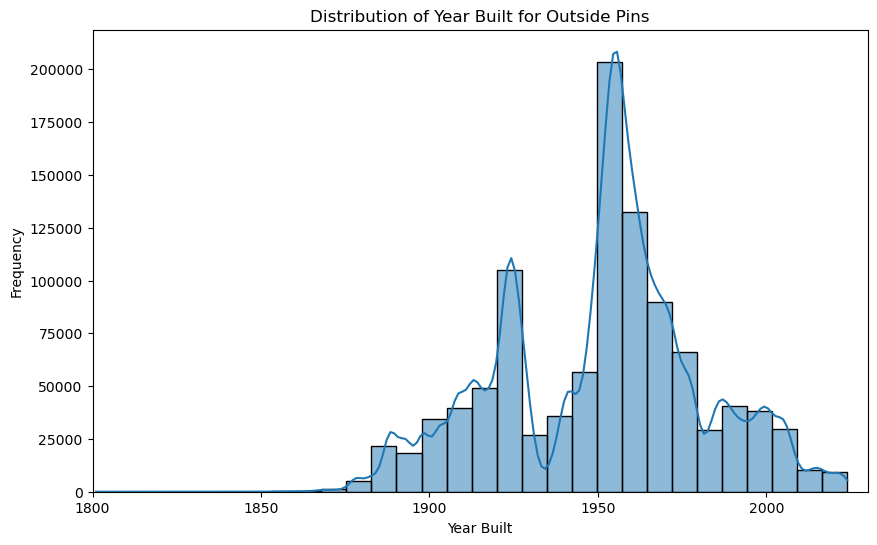

In [34]:
# Plot Year Built distribution with specified bins
plt.figure(figsize=(10,6))
sns.histplot(df['year_built'], bins=30, kde=True)

# Set x-axis limits and labels to focus on the range of year_built (1900 to 2025)
plt.xlim(1800, 2030)
plt.title("Distribution of Year Built for Outside Pins")
plt.xlabel("Year Built")
plt.ylabel("Frequency")
plt.show()

#### Properties that are not part of connected communities are constructed mainly from 1940s to 1975, with some of them built during the year 1925.

####  Properties outside connected communities, especially those built between 1925 and 1975, are likely a result of historical growth patterns during periods of suburban expansion, technological limitations, and economic factors that made land outside cities more accessible for residential development.

In [35]:
# Construction Quality & Repair Condition distribution
print("\nConstruction Quality Distribution:")
print(df['construction_quality'].value_counts())


Construction Quality Distribution:
construction_quality
Average    1030965
Deluxe       10935
Poor           711
Name: count, dtype: int64


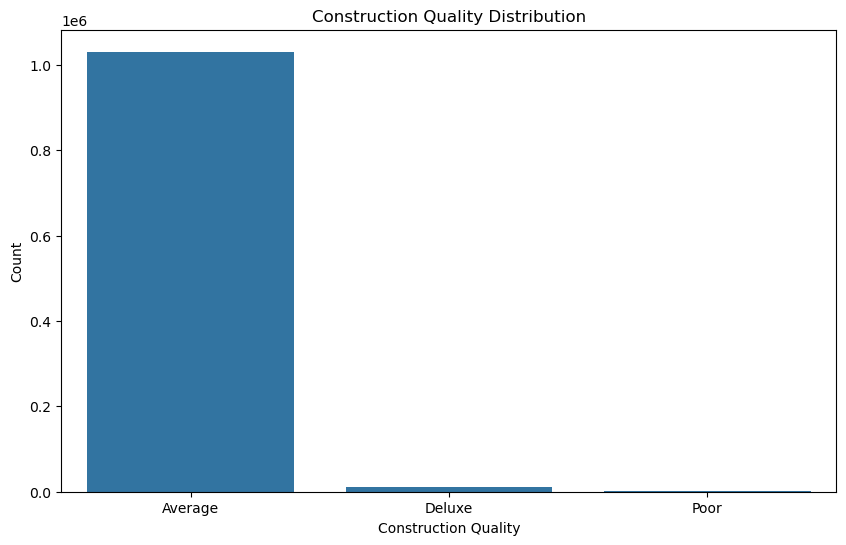

In [36]:
plt.figure(figsize=(10,6))
sns.countplot(x='construction_quality', data=df)
plt.title("Construction Quality Distribution")
plt.xlabel("Construction Quality")
plt.ylabel("Count")
plt.show()

#### Properties outside connected communities generally have good to high construction quality, indicating that these areas maintain a certain standard of living same as connected ones.


Repair Condition Distribution:
repair_condition
Average          1028961
Above Average       8870
Below Average       4961
Name: count, dtype: int64


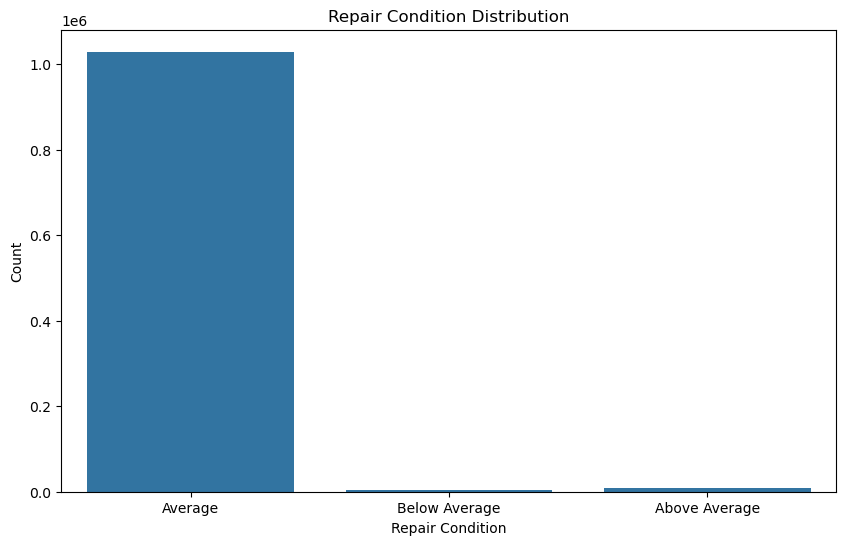

In [37]:
print("\nRepair Condition Distribution:")
print(df['repair_condition'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(x='repair_condition', data=df)
plt.title("Repair Condition Distribution")
plt.xlabel("Repair Condition")
plt.ylabel("Count")
plt.show()

#### Similar to connected communities

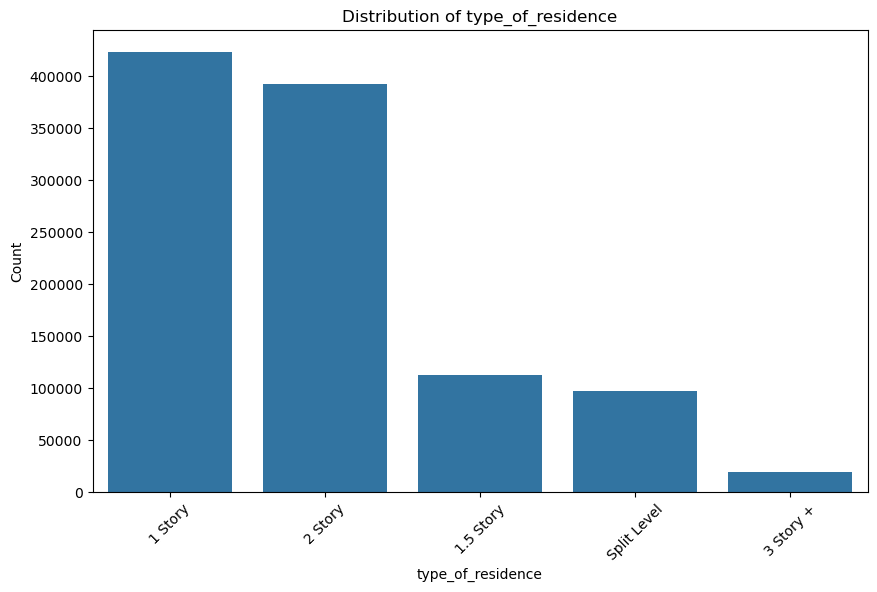

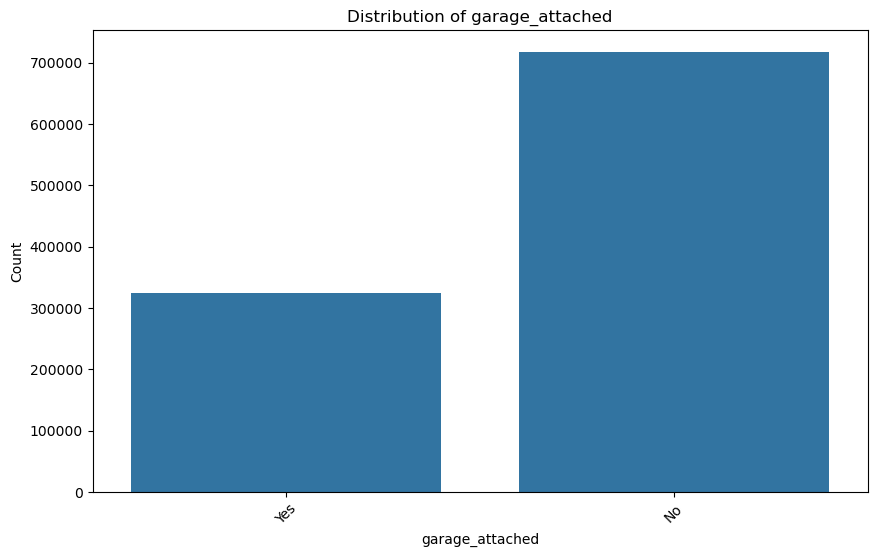

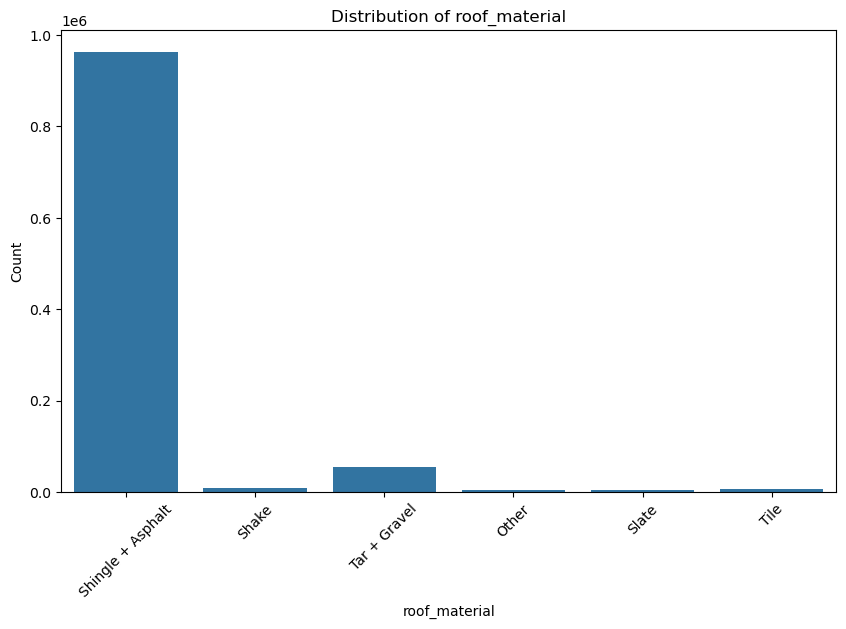

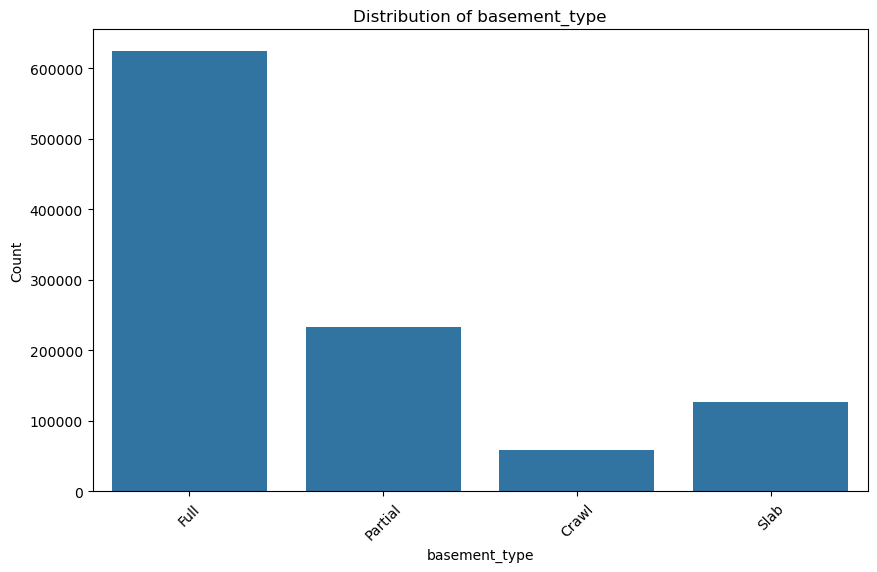

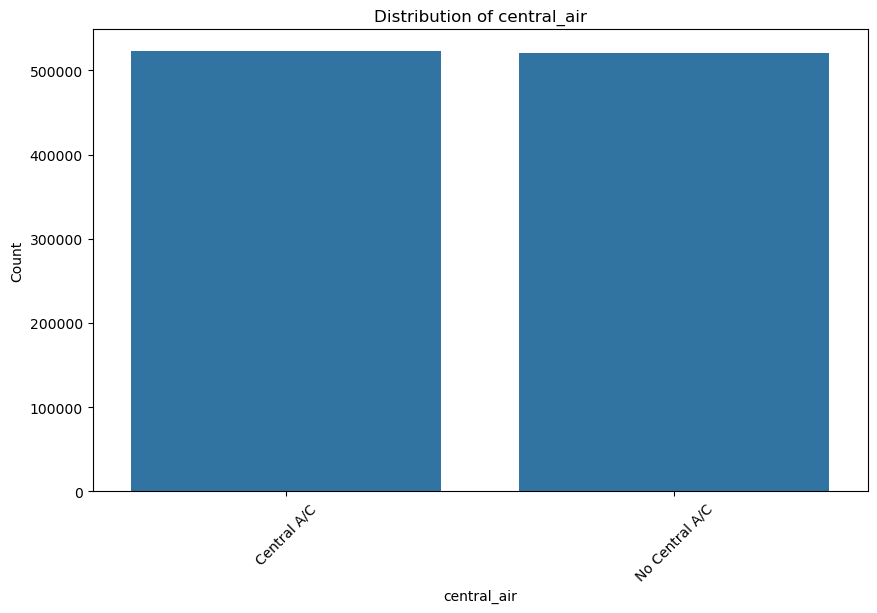

In [38]:
# 4. Categorical Variables Analysis
categorical_columns = ['type_of_residence', 'garage_attached', 'roof_material', 'basement_type', 'central_air']

# Plot distribution of categorical variables
for col in categorical_columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

#### Type of Residence: Most properties are 1 and 2 story with very few greater than that.
#### Garage Attached: Few homes have attached garages, connected communities rely on street or shared parking.
#### Roof Material: Only Asphalt shingles dominate, indicating a standardized construction trend.
#### Basement Type: The distribution of full basements, crawl spaces, or slab foundations reflects climate and soil conditions.
#### Central Air: equal distribution of homes with central air conditioning and those without it.

In [39]:
# 5. Generate Summary of Insights
print("\nKey Insights:")
print(f"- Average building square footage: {df['building_sqft'].mean()} sq ft")
print(f"- Average number of bedrooms: {df['num_bedrooms'].mean()}")
print(f"- Proportion with garages: {df['garage_attached'].value_counts(normalize=True).get('Yes', 0)}")
print(f"- Proportion with central air: {df['central_air'].value_counts(normalize=True).get('Yes', 0)}")


Key Insights:
- Average building square footage: 1781.6743826553754 sq ft
- Average number of bedrooms: 3.487387479826201
- Proportion with garages: 0.31148921218311926
- Proportion with central air: 0


#### The average size of the homes is approximately 1,782 square feet, indicating a moderately spacious living space for the properties analyzed. This suggests that these homes are likely designed to accommodate average-sized families.

#### On average, homes have about 3.5 bedrooms, which is typical for many family homes. This indicates that the properties are likely aimed at medium-sized families, with a focus on providing enough space for different members.

#### Around 31.15% of the homes have garages, suggesting that a significant portion of homes might not have garages or parking spaces. This could reflect urban properties or those in areas where garage space is either limited or not prioritized.

## Visualizing all pins on map

In [ ]:
# Load the datasets
pin_lat_long = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/pin_lat_long.csv")  
filtered_highdensity = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/filtered_high_density_zoning.csv")  

# Create a new column for matching pins in filtered_highdensity
filtered_highdensity["in_connected_community"] = "inside"

# Merge datasets on 'pin' (left join to retain all rows in pin_lat_long)
pin_lat_long = pin_lat_long.merge(filtered_highdensity[['pin', 'in_connected_community']], on='pin', how='left')

# Fill NaN values with "outside" for pins not in filtered_highdensity
pin_lat_long["in_connected_community"] = pin_lat_long["in_connected_community"].fillna("outside")

# Save the updated file
output_file = "C:/Users/kaur6/Downloads/Urban Analytics/pin_lat_long_in_out.csv"
pin_lat_long.to_csv(output_file, index=False)

print(f"Updated dataset saved: {output_file}")

In [ ]:
# Load dataset
df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/pin_lat_long_in_out.csv")

# Drop missing latitude/longitude
df = df.dropna(subset=['latitude', 'longitude'])

# Split categories
inside_pins = df[df['in_connected_community'] == 'inside']
outside_pins = df[df['in_connected_community'] == 'outside']

# Sample 5,000 inside pins
inside_sample = inside_pins.sample(n=5000, random_state=42) if len(inside_pins) > 5000 else inside_pins

# Sample 45,000 outside pins
outside_sample = outside_pins.sample(n=45000, random_state=42) if len(outside_pins) > 45000 else outside_pins

# Combine samples
balanced_sample = pd.concat([inside_sample, outside_sample])

# Shuffle dataset
balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
output_path = "C:/Users/kaur6/Downloads/Urban Analytics/balanced_50k_dataset.csv"
balanced_sample.to_csv(output_path, index=False)

print(f"✅ Balanced dataset saved: {output_path}")

In [ ]:
# Load balanced dataset
df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/balanced_50k_dataset.csv")

# Create base map centered at the mean latitude and longitude
map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Function to add CircleMarkers
def add_circle_markers(pins, color, radius):
    for _, pin in pins.iterrows():
        folium.CircleMarker(
            location=[pin['latitude'], pin['longitude']],
            radius=radius,
            color=color,
            fill=True,
            fill_opacity=0.6
        ).add_to(m)

# Split inside and outside pins
inside_pins = df[df['in_connected_community'] == 'inside']
outside_pins = df[df['in_connected_community'] == 'outside']

# Add inside (blue) and outside (red) points to the map
add_circle_markers(inside_pins, color='blue', radius=2)
add_circle_markers(outside_pins, color='red', radius=2)

# Save the map
output_path = "C:/Users/kaur6/Downloads/Urban Analytics/non_clustered_map.html"
m.save(output_path)

print(f"✅ Map saved: {output_path}. Open it in a browser.")

In [ ]:
# Load datasets
unique_pins = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/unique_pins_with_cc_status.csv")
parcel_cc = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/Parcel_CC.csv", low_memory=False)

# Convert both columns to string type to avoid datatype mismatch
unique_pins["pin"] = unique_pins["pin"].astype(str)
parcel_cc["name"] = parcel_cc["name"].astype(str)

# Merge datasets
merged_df = unique_pins.merge(parcel_cc, left_on="pin", right_on="name", how="inner")

# Drop the redundant pin10 column if needed
merged_df.drop(columns=["name"], inplace=True)

# Save the filtered dataset
merged_df.to_csv("C:/Users/kaur6/Downloads/Urban Analytics/census_perc_pop.csv", index=False)

print("Filtered dataset saved as 'census_perc_pop.csv'")

In [40]:
merged_df = pd.read_csv("C:/Users/kaur6/Downloads/Urban Analytics/census_perc_pop.csv", low_memory=False)
# Clean up the 'in_connected_comunity' column (if needed)
merged_df['in_connected_community'] = merged_df['in_connected_community'].str.strip().str.lower()
# Grouping by 'in_connected_comunity' column
connected_df = merged_df[merged_df['in_connected_community'] == 'inside'] 
not_connected_df = merged_df[merged_df['in_connected_community'] != 'inside']  
# Calculate mean of census data for both groups
connected_avg = connected_df[['tract_white_perc', 'tract_black_perc']].mean()
not_connected_avg = not_connected_df[['tract_white_perc', 'tract_black_perc']].mean()
print("Average demographic information for connected communities:")
print(connected_avg)
print("\nAverage demographic information for non-connected communities:")
print(not_connected_avg)

Average demographic information for connected communities:
tract_white_perc    0.310042
tract_black_perc    0.391647
dtype: float64

Average demographic information for non-connected communities:
tract_white_perc    0.366575
tract_black_perc    0.321173
dtype: float64


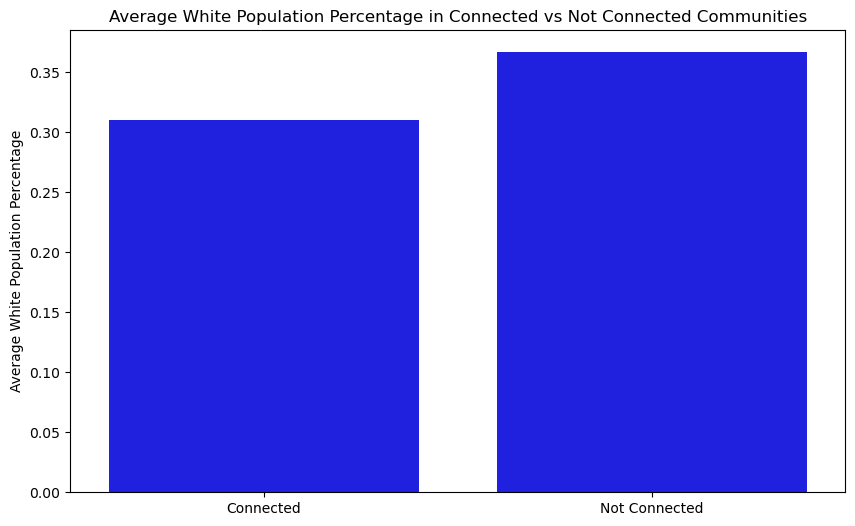

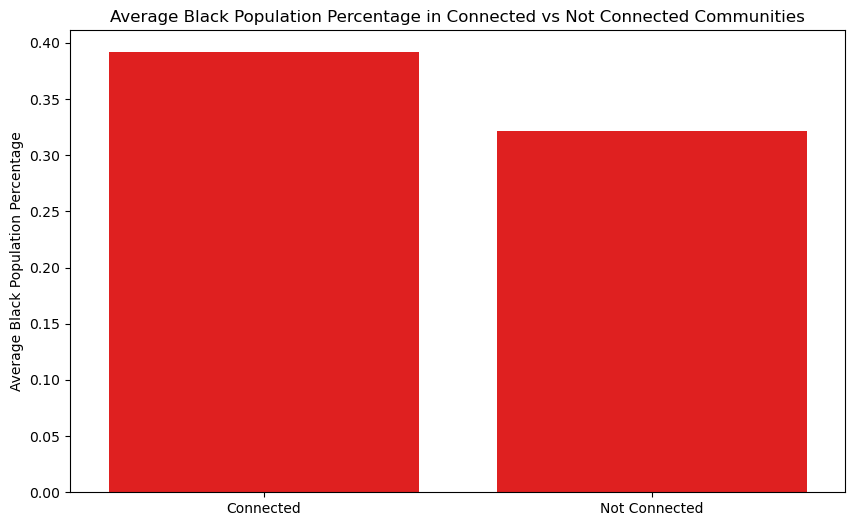

In [41]:
# Plotting comparison for tract_white_perc and tract_black_perc
plt.figure(figsize=(10, 6))
sns.barplot(x=['Connected', 'Not Connected'], y=[connected_avg['tract_white_perc'], not_connected_avg['tract_white_perc']], color='blue')
plt.title('Average White Population Percentage in Connected vs Not Connected Communities')
plt.ylabel('Average White Population Percentage')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=['Connected', 'Not Connected'], y=[connected_avg['tract_black_perc'], not_connected_avg['tract_black_perc']], color='red')
plt.title('Average Black Population Percentage in Connected vs Not Connected Communities')
plt.ylabel('Average Black Population Percentage')
plt.show()

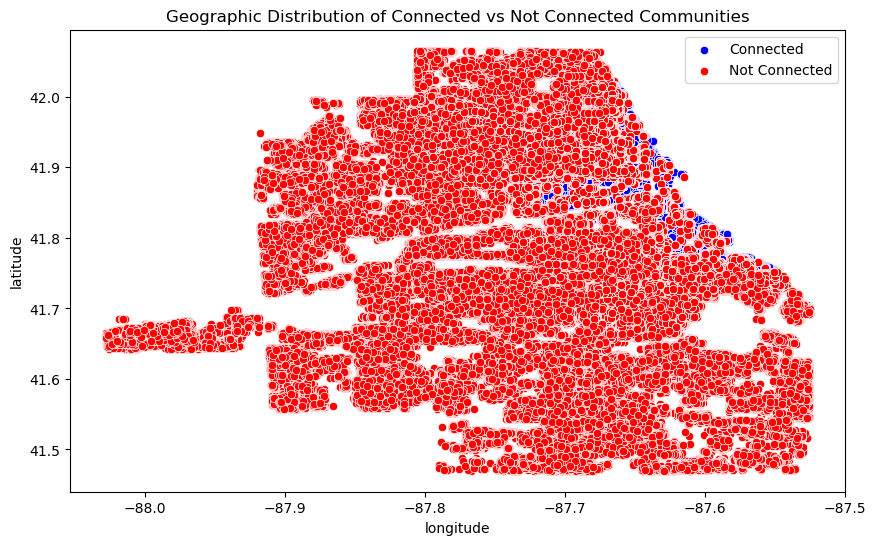

In [42]:
# Scatter plot for longitude and latitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=connected_df, x='longitude', y='latitude', color='blue', label='Connected')
sns.scatterplot(data=not_connected_df, x='longitude', y='latitude', color='red', label='Not Connected')
plt.title('Geographic Distribution of Connected vs Not Connected Communities')
plt.legend()
plt.show()

#### Red Points (Not Connected Communities): These are widespread across the cook county, covering most of the geographic region.

#### Blue Points (Connected Communities): These are concentrated in a specific region i.e. Chicago city, particularly in the northeastern part of the map.

#### Pattern: The clustering of connected communities suggests that internet or infrastructure connectivity is only available in a specific area, which is likely  more developed urban region. The vast majority of communities remain unconnected.

#### Interpretation: The map highlights digital inequality, with a clear divide between connected and not connected areas. The connected communities may have better infrastructure, while the rest of the region lacks access.

In [43]:
# T-test to compare 'tract_white_perc' between connected and not connected
t_stat, p_val = stats.ttest_ind(connected_df['tract_white_perc'], not_connected_df['tract_white_perc'], nan_policy='omit')
print(f"T-test for tract_white_perc: t-statistic = {t_stat}, p-value = {p_val}")

# T-test to compare 'tract_black_perc' between connected and not connected
t_stat, p_val = stats.ttest_ind(connected_df['tract_black_perc'], not_connected_df['tract_black_perc'], nan_policy='omit')
print(f"T-test for tract_black_perc: t-statistic = {t_stat}, p-value = {p_val}")

T-test for tract_white_perc: t-statistic = -72.46141578353486, p-value = 0.0
T-test for tract_black_perc: t-statistic = 72.70996761532211, p-value = 0.0


#### Not much difference, but connected communities have more Black population than White and viceversa in non connected communities.